In [ ]:
%pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
REPLACEMENT_COST = 500
PROFITS = 150

PROB = 0.9
GAMMA = 0.8

ACTION_SET = ['keep', 'replace']
STATE_SET = range(1, 11)

# Production

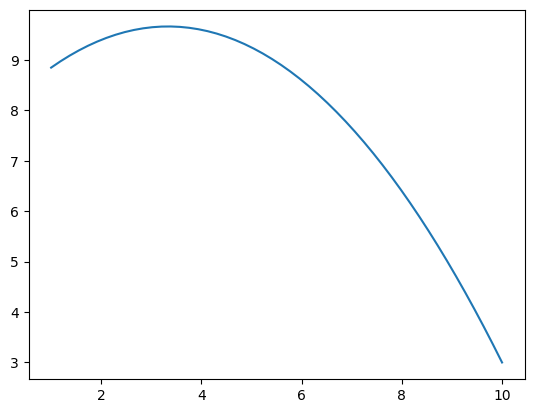

In [4]:
def production(x):
    return 8 + x - 0.15 * x**2

x = np.linspace(1, 10)
plt.plot(x, production(x))

# Action

In [5]:
def get_actions(state, bool=False):
    if state<10:
        if bool: return [0,1]
        else: return ['keep', 'replace']
    if state==10:
        if bool: return [1]
        else: return ['replace']

# Transition

In [6]:
def transition(state, action, new_state, prob=PROB):
    if (action=='keep' or action==0) and (state<=8) and (new_state==state+1):
        return prob
    if (action=='keep' or action==0) and (state<=8) and (new_state==state+2):
        return 1-prob
    if (action=='keep' or action==0) and (state==9) and (new_state==10):
        return 1
    if (action=='replace' or action==1) and (new_state==1):
        return 1
    else:
        return 0 


# Reward

In [7]:
def reward(state, action, profits=PROFITS, replacement_cost=REPLACEMENT_COST):
    if action == 'keep' or action == 0:
        return production(state) * profits
    if action == 'replace' or action == 1:
        return production(state) * profits - replacement_cost

# Value iteration

### Idea
Repeatedly update an estimate of the optimal value function according to Bellman optimality equation.

### Procedure
- Initialize $V_0(s) = 0, \forall s \in \mathcal{S}$: no time steps left means an 
expected reward sum of zero
- Update $V_{k+1}(s) = \underset{a \in \mathcal{A}}{\max} \sum_{s' \in \mathcal{S}} T(s, a ,s') [ R(s, a, s') + \gamma V_k(s')] $
- Repeat until convergence

In [8]:
def value_iteration(states, actions, transitions, rewards, gamma, theta=1e-6):
    """
    states (list):
        A list of states
    actions (func):
        A function that returns the available actions for a given state
    transitions (func):
        A function that returns the probability of transitionning from a state s to a state s' given action a
    rewards (func):
        A function that returns a reward when action a is executed from state s 
    theta (float): 
        stopping criterion 
    """

    value_function = np.zeros(len(states))
    policy = list(np.zeros(len(states)))

    while True:

        delta = 0
        for i, state in enumerate(states):

            v = value_function[i]

            action_values = []
            for action in actions(state):

                action_values.append(
                    rewards(state, action) \
                        + sum(gamma * transitions(state, action, new_state) * value_function[new_state - 1]
                              for new_state in STATE_SET)
                )

            value_function[i] = max(action_values)
            delta = max(delta, abs(v - value_function[i]))

        if delta < theta:
            break

    # Policy
    for i, state in enumerate(states):

        action_values = []
        for action in actions(state):

            action_values.append(
                rewards(state, action) \
                    + sum(gamma * transitions(state, action, new_state) * value_function[new_state - 1]
                          for new_state in states)
            )

        best_action = actions(state)[np.argmax(action_values)]
        policy[i] = best_action

    return policy, value_function

# Run value iteration
optimal_policy, optimal_value_function = value_iteration(STATE_SET, get_actions, transition, reward, GAMMA)

# Print the results
print("Optimal Policy:")
print(optimal_policy)
print("\nOptimal Value Function:")
print(optimal_value_function)

Optimal Policy:
['keep', 'keep', 'keep', 'keep', 'keep', 'replace', 'replace', 'replace', 'replace', 'replace']

Optimal Value Function:
[6655.40264752 6667.97684733 6586.99147687 6441.78730836 6267.55769381
 6114.32211801 5971.82211801 5784.32211801 5551.82211801 5274.32211801]



Optimal Policy:
['keep', 'keep', 'keep', 'keep', 'replace', 'replace', 'replace', 'replace', 'replace', 'replace']

Optimal Value Function:
[6823.82114149 6873.90988243 6838.82533416 6749.44553005 6646.55691319
 6549.05691319 6406.55691319 6219.05691319 5986.55691319 5709.05691319]

Optimal Policy:
['keep', 'keep', 'keep', 'keep', 'replace', 'replace', 'replace', 'replace', 'replace', 'replace']

Optimal Value Function:
[6810.30601837 6857.38473775 6818.61259753 6724.79585124 6615.7448147
 6518.2448147  6375.7448147  6188.2448147  5955.7448147  5678.2448147 ]

Optimal Policy:
['keep', 'keep', 'keep', 'keep', 'replace', 'replace', 'replace', 'replace', 'replace', 'replace']

Optimal Value Function:
[6796.79089526 6840.85959306 6798.3998609  6700.14617244 6584.93271621
 6487.43271621 6344.93271621 6157.43271621 5924.93271621 5647.43271621]

Optimal Policy:
['keep', 'keep', 'keep', 'keep', 'replace', 'replace', 'replace', 'replace', 'replace', 'replace']

Optimal Value Function:
[6783.27

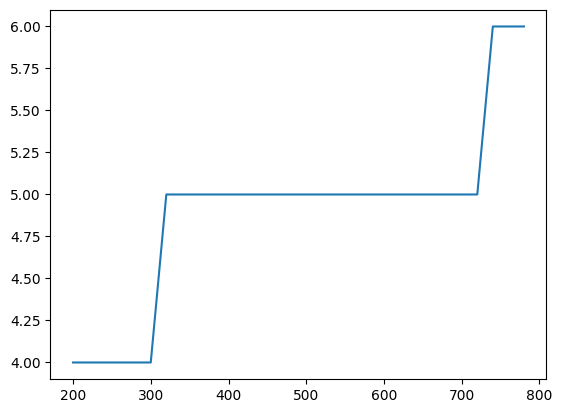

In [9]:
first_replaces = list()

replacement_costs = range(200, 800, 20)
for replacement_cost in replacement_costs:
    reward_c = lambda s, a: reward(s, a, replacement_cost=replacement_cost)
    optimal_policy, optimal_value_function = value_iteration(STATE_SET, get_actions, transition, reward_c, GAMMA)
    print("\nOptimal Policy:")
    print(optimal_policy)
    print("\nOptimal Value Function:")
    print(optimal_value_function)
    first_replaces.append(optimal_policy.index("replace"))

plt.plot(replacement_costs, first_replaces)   

# Policy iteration
Focus on the quality of a policy (to find the optimal one)
- Evaluate a policy
- Greedily improve the policy

### Policy evaluation

Value function for a given policy $\pi$:
\begin{equation}
    V^{\pi} = \mathbb{E}[\sum_{t=0}^{\infty} \gamma^t R(s_t, a_t, s_{t+1}) \mid s_0, a_t=\pi(s_t), T(s_t, a_t, s_{t+1})]
\end{equation}

- the expectation runs over the states

Value function for a given policy and state:
\begin{equation}
    V^{\pi}(s) = \sum_{s' \in \mathcal{S}} T(s, \pi(s), s')[R(s, \pi(s), s') + \gamma V^{\pi}(s')]
\end{equation}

We can compute the value function recursively:
\begin{equation}
    V_0^{\pi}(s) = 0
\end{equation}

\begin{equation}
    V_{k+1}^{\pi}(s) = \sum_{s' \in \mathcal{S}} T(s, \pi(s), s')[R(s, \pi(s), s') + \gamma V_k^{\pi}(s')]
\end{equation}


In [10]:

def policy_iteration(states, actions, transitions, rewards, gamma, theta=1e-6):
    """
    states (list):
        A list of states
    actions (func):
        A function that returns the available actions for a given state
    transitions (func):
        A function that returns the probability of transitionning from a state s to a state s' given action a
    rewards (func):
        A function that returns a reward when action a is executed from state s 
    theta (float): 
        stopping criterion 
    """
    
    value_function = np.zeros(len(states))
    policy = [np.random.choice(actions(s)) for s in states]

    while True:

        # Policy Evaluation

        while True:
            
            delta = 0
            for i, state in enumerate(states):
                
                v = value_function[i]
                action = policy[i]

                value_function[i] = rewards(state, action) \
                    + sum(gamma * transitions(state, action, new_state) * value_function[new_state - 1]
                          for new_state in states)

                delta = max(delta, abs(v - value_function[i]))

            if delta < theta:
                break

        # Policy Improvement

        policy_stable = True
        for i, state in enumerate(states):
            
            old_action = policy[i]
            action_values = {}

            for action in actions(state):

                action_values[action] = rewards(state, action)\
                    + sum(gamma * transitions(state, action, new_state) * value_function[new_state - 1]
                          for new_state in states)

            best_action = max(action_values, key=action_values.get)
            policy[i] = best_action

            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            break

    return policy, value_function

# Run policy iteration
optimal_policy, optimal_value_function = policy_iteration(STATE_SET, get_actions, transition, reward, GAMMA)

# Print the results
print("\nOptimal Policy:")
print(optimal_policy)
print("\nOptimal Value Function:")
print(optimal_value_function)


Optimal Policy:
['keep', 'keep', 'keep', 'keep', 'keep', 'replace', 'replace', 'replace', 'replace', 'replace']

Optimal Value Function:
[6655.40264758 6667.97684736 6586.99147684 6441.78730833 6267.55769383
 6114.32211806 5971.82211806 5784.32211806 5551.82211806 5274.32211806]


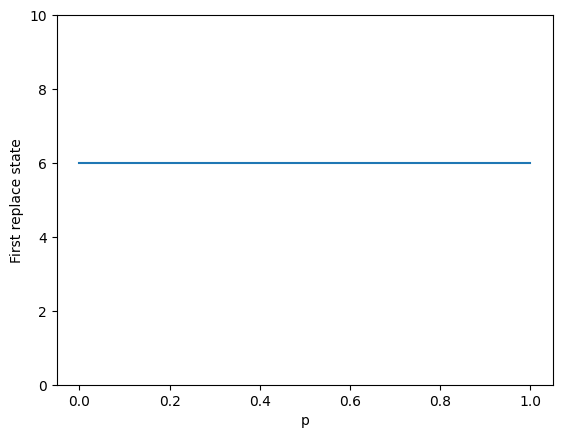

In [11]:
first_replaces = list()

probs = np.linspace(0, 1, 10)
for prob in probs:
    transition_p = lambda s, a, new_s: transition(s, a, new_s, prob=prob)
    optimal_policy, optimal_value_function = policy_iteration(STATE_SET, get_actions, transition_p, reward, GAMMA)

    first_replaces.append(optimal_policy.index("replace")+1)

plt.plot(probs, first_replaces)    
plt.xlabel('p')
plt.ylabel('First replace state')
plt.ylim(0, 10)

plt.savefig('sensitivity_to_p.png')


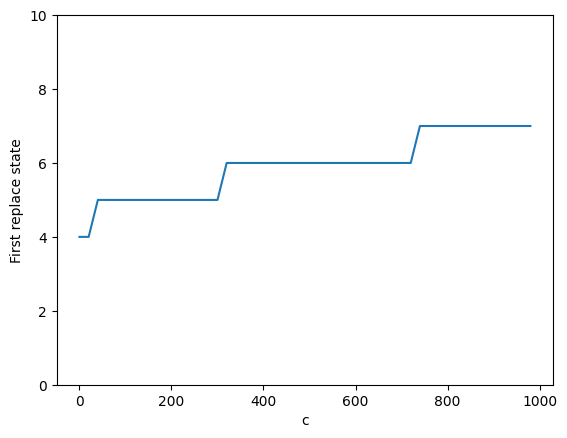

In [12]:
first_replaces = list()

replacement_costs = range(0, 1000, 20)
for replacement_cost in replacement_costs:
    reward_c = lambda s, a: reward(s, a, replacement_cost=replacement_cost)
    optimal_policy, optimal_value_function = policy_iteration(STATE_SET, get_actions, transition, reward_c, GAMMA)
    first_replaces.append(optimal_policy.index("replace")+1)

plt.plot(replacement_costs, first_replaces)   
plt.xlabel('c')
plt.ylabel('First replace state')
plt.ylim(0, 10)
plt.savefig('sensitivity_to_c.png')

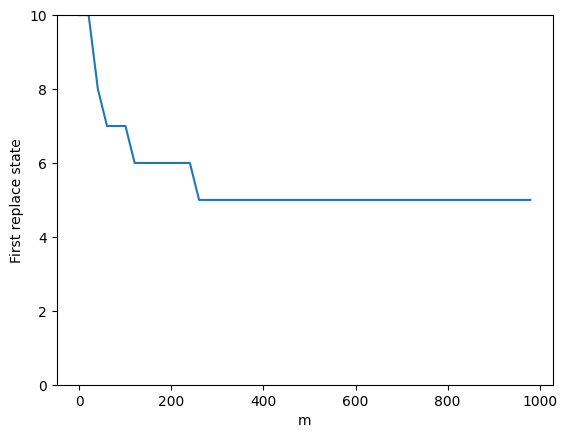

In [13]:
first_replaces = list()

profits = range(0, 1000, 20)
for profit in profits:
    reward_p = lambda s, a: reward(s, a, profits=profit)
    optimal_policy, optimal_value_function = policy_iteration(STATE_SET, get_actions, transition, reward_p, GAMMA)
    first_replaces.append(optimal_policy.index("replace")+1)

plt.plot(profits, first_replaces)   
plt.xlabel('m')
plt.ylabel('First replace state')
plt.ylim(0, 10)
plt.savefig('sensitivity_to_m.png')

# Linear programming

In [14]:
from scipy.optimize import linprog

In [15]:
p = PROB
gamma = GAMMA
m = PROFITS
c = REPLACEMENT_COST 

In [16]:
Ls = np.arange(1, 11)

# The production function y(s)
def y(s):
    return 8 + s - 0.15 * s**2

In [17]:
def R(s, a, s_prime):
    if a == 'replace':
        return y(s) * m - c
    else:
        return y(s) * m

In [18]:
# Number of states
num_states = 10

# Objective function
c_vector = np.ones(num_states)

# Coefficients for the constraints
A_ub = np.zeros((num_states * 2, num_states))
b_ub = np.zeros(num_states * 2)

# Set up the constraints for each state (s), the transition function is implicitely integrated in the constraints
for i, s in enumerate(Ls):
    # Constraint for action 'keep'
    A_ub[i, i] = -1  # Coefficient for V(s) on the left-hand side of the inequality
    if s < 9:
        A_ub[i, i+1] += p * gamma  # Coefficient for V(s+1)
        A_ub[i, min(i+2, num_states-1)] += (1 - p) * gamma  # Coefficient for V(s+2) or V(10)
        b_ub[i] = -p * R(s, 'keep', s+1) - (1 - p) * R(s, 'keep', min(s+2, 10))
    else:
        A_ub[i, 0] += gamma  # Coefficient for V(1)
        b_ub[i] = -R(s, 'keep', 1)

    # Constraint for action 'replace'
    A_ub[num_states + i, i] = -1  # Coefficient for V(s) on the left-hand side of the inequality
    A_ub[num_states + i, 0] += gamma  # Coefficient for V(1)
    b_ub[num_states + i] = -R(s, 'replace', 1)

# Bounds for the decision variables
bounds = [(0, None) for _ in range(num_states)]

# Solve the linear programming problem
res = linprog(c_vector, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
res.x, res.success

(array([6655.40265052, 6667.97685021, 6586.99147962, 6441.78731099,
        6267.55769633, 6114.32212041, 5971.82212041, 5784.32212041,
        6051.82212041, 5774.32212041]),
 True)

In [19]:
def best_action(s, V_star_L, p, m, c, gamma):
    # Immediate reward when keeping or replacing the machine
    keep_reward = y(s) * m
    replace_reward = y(1) * m - c

    # Expected value if we keep the machine
    if s < 10:
        keep_value = p * (keep_reward + gamma * V_star_L[min(s, 9)]) + \
                     (1 - p) * (keep_reward + gamma * V_star_L[min(s+1, 9)])
    else:
        keep_value = keep_reward + gamma * V_star_L[0]  # If s == 10, it can only go to state 1

    # Expected value if we replace the machine
    replace_value = replace_reward + gamma * V_star_L[0]

    return 'keep' if keep_value >= replace_value else 'replace'

# Assuming V_star_L is the optimal value function obtained from the linear programming problem
V_star_L = np.array([
    130118.95690403, 130102.03303929, 130005.50975775, 129869.93782968,
    129736.31466164, 129645.26733499, 129645.26733499, 129645.26733499,
    129645.26733499, 129645.26733499
])

# Print the optimal action for each state
optimal_policy = [best_action(s, V_star_L, p, m, c, gamma) for s in Ls]
optimal_policy


['keep',
 'keep',
 'keep',
 'keep',
 'keep',
 'keep',
 'replace',
 'replace',
 'replace',
 'replace']